### Import Libraries

In [7]:
import importlib
import os
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from actions.helpers import check_model_availability, filter_and_prepare_model_results
from models import gpt

importlib.reload(gpt)

from models.gpt import GPTViolenceEvaluator
# Import Ollama evaluator
from models import ollama
importlib.reload(ollama)
from models.ollama import OllamaViolenceEvaluator
from models import qwen_judge
importlib.reload(qwen_judge)
from models.qwen_judge import QwenViolenceEvaluator


In [76]:
import importlib
from actions import helpers
importlib.reload(helpers)
from actions.helpers import check_model_availability, filter_and_prepare_model_results, merge_consecutive_segments

In [8]:
MODEL_NAME = "gpt-5"
OLLAMA_MODEL_NAME = "qwen3:14b-q8_0"
# Output paths for 4 experiments
API_BASED_OUTPUT = "../../data/results/zero_shot_classification/llm_judge_api_based"
OPEN_SOURCE_OUTPUT = "../../data/results/zero_shot_classification/llm_judge_open_source"
OLLAMA_OPEN_SOURCE_OUTPUT = "../../data/results/zero_shot_classification/llm_judge_ollama/incremental_results.json"
QWEN_OPEN_SOURCE_OUTPUT = "../../data/results/zero_shot_classification/llm_judge_qwen/incremental_results_alt_prompt2.json"
# Model availability tracking
MODEL_AVAILABILITY_OUTPUT = "../../data/metadata/model_availability.csv"
FILTERED_RESULTS_OUTPUT = "../../data/results/zero_shot_classification/filtered_model_results.json"
MERGED_RESULTS_OUTPUT = "../../data/results/zero_shot_classification/merged_model_results.json"

### Get video paths and model results

In [3]:
# Get video paths from dataset metadata
video_metadata = pd.read_csv(os.getenv("VIDEO_METADATA_PATH"))
video_paths = video_metadata[~video_metadata['is_size_outlier']].set_index('video_path')[['video_name', 'download_url']].to_dict('index')
print(f"Total videos to process: {len(video_paths)}")

Total videos to process: 3556


In [4]:
model_files = {
    "clip": "../../data/results/clip_results.json",
    "xclip": "../../data/results/xclip_results.json",
    "clap": "../../data/results/clap_results.json",
    "beats": "../../data/results/beats_results.json",
    "gemini": "../../data/results/gemini_transcripts.json",
    "whisper": "../../data/results/whisper_transcripts.json",
    "qwen": "../../data/results/qwen_dashscope_transcripts_final.json"
}

In [7]:
# Get prompt
prompt_path = "../../data/prompts/llm_judge.txt"
with open(prompt_path, "r", encoding="utf-8") as f:
    prompt = f.read()

### Analyze Probability Distributions

In [ ]:
def analyze_probability_distributions_raw(
    model_files: dict, 
    models: list = ['clip', 'xclip', 'clap', 'beats']
):
    """
    Analyze probability distributions from RAW model results (before any filtering).
    
    Args:
        model_files: Dict of model_name -> results.json path
        models: List of models to analyze
    
    Returns:
        DataFrame with probability statistics
    """
    
    all_probs = {model: [] for model in models}
    
    # Load and collect all probabilities from raw results
    for model_name in models:
        if model_name not in model_files:
            continue
        
        file_path = model_files[model_name]
        
        with open(file_path, "r", encoding="utf-8") as f:
            results = json.load(f)
        
        # Collect probabilities from each video's results
        for result in results:
            if 'error' in result:
                continue
                
            response = result.get('response', [])
            if not isinstance(response, list):
                continue
            
            # Extract probabilities from labels
            for item in response:
                labels = item.get('labels', {})
                if isinstance(labels, dict):
                    for label, prob in labels.items():
                        all_probs[model_name].append(prob)
    
    # Print statistics
    print(f"{'='*80}")
    print("PROBABILITY DISTRIBUTION ANALYSIS (RAW DATA)")
    print(f"{'='*80}\n")
    
    stats_data = []
    
    for model_name in models:
        if not all_probs[model_name]:
            print(f"{model_name.upper()}: No data found")
            continue
        
        probs = np.array(all_probs[model_name])
        
        print(f"{model_name.upper()}:")
        print(f"  Total labels: {len(probs):,}")
        print(f"  Mean:   {probs.mean():.3f}")
        print(f"  Median: {np.median(probs):.3f}")
        print(f"  Std:    {probs.std():.3f}")
        print(f"\n  Percentiles:")
        percentiles = [10, 25, 50, 75, 90, 95, 99]
        for p in percentiles:
            val = np.percentile(probs, p)
            count_above = (probs >= val).sum()
            pct_above = (count_above / len(probs)) * 100
            print(f"    {p:2d}th: {val:.3f} ({count_above:6,} labels, {pct_above:5.1f}% above)")
        
        # Test different thresholds
        print(f"\n  Labels retained at different thresholds:")
        thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
        for thresh in thresholds:
            count = (probs >= thresh).sum()
            pct = (count / len(probs)) * 100
            print(f"    ≥{thresh:.2f}: {count:6,} labels ({pct:5.1f}%)")
        
        print()
        
        stats_data.append({
            'model': model_name,
            'total_labels': len(probs),
            'mean': probs.mean(),
            'median': np.median(probs),
            'std': probs.std(),
            'p25': np.percentile(probs, 25),
            'p50': np.percentile(probs, 50),
            'p75': np.percentile(probs, 75),
            'p90': np.percentile(probs, 90)
        })
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, model_name in enumerate(models):
        if not all_probs[model_name]:
            continue
        
        ax = axes[idx]
        probs = all_probs[model_name]
        
        # Histogram
        ax.hist(probs, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        
        # Add vertical lines for different thresholds
        ax.axvline(0.10, color='red', linestyle='--', linewidth=2, label='0.10')
        ax.axvline(0.20, color='green', linestyle='--', linewidth=2, label='0.20 (recommended)')
        ax.axvline(np.median(probs), color='orange', linestyle=':', linewidth=2, label=f'Median ({np.median(probs):.2f})')
        
        ax.set_xlabel('Probability', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'{model_name.upper()} - Probability Distribution', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../data/analysis/probability_distributions_raw.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pd.DataFrame(stats_data)


PROBABILITY DISTRIBUTION ANALYSIS (RAW DATA)

CLIP:
  Total labels: 5,930,148
  Mean:   0.185
  Median: 0.134
  Std:    0.152

  Percentiles:
    10th: 0.064 (5,343,588 labels,  90.1% above)
    25th: 0.090 (4,456,438 labels,  75.1% above)
    50th: 0.134 (2,965,286 labels,  50.0% above)
    75th: 0.225 (1,487,835 labels,  25.1% above)
    90th: 0.384 (593,122 labels,  10.0% above)
    95th: 0.514 (296,997 labels,   5.0% above)
    99th: 0.773 (59,716 labels,   1.0% above)

  Labels retained at different thresholds:
    ≥0.05: 5,618,121 labels ( 94.7%)
    ≥0.10: 4,068,691 labels ( 68.6%)
    ≥0.15: 2,581,466 labels ( 43.5%)
    ≥0.20: 1,762,369 labels ( 29.7%)
    ≥0.25: 1,268,996 labels ( 21.4%)
    ≥0.30: 942,552 labels ( 15.9%)

XCLIP:
  Total labels: 915,162
  Mean:   0.172
  Median: 0.125
  Std:    0.139

  Percentiles:
    10th: 0.063 (826,319 labels,  90.3% above)
    25th: 0.085 (692,889 labels,  75.7% above)
    50th: 0.125 (462,074 labels,  50.5% above)
    75th: 0.206 (229,

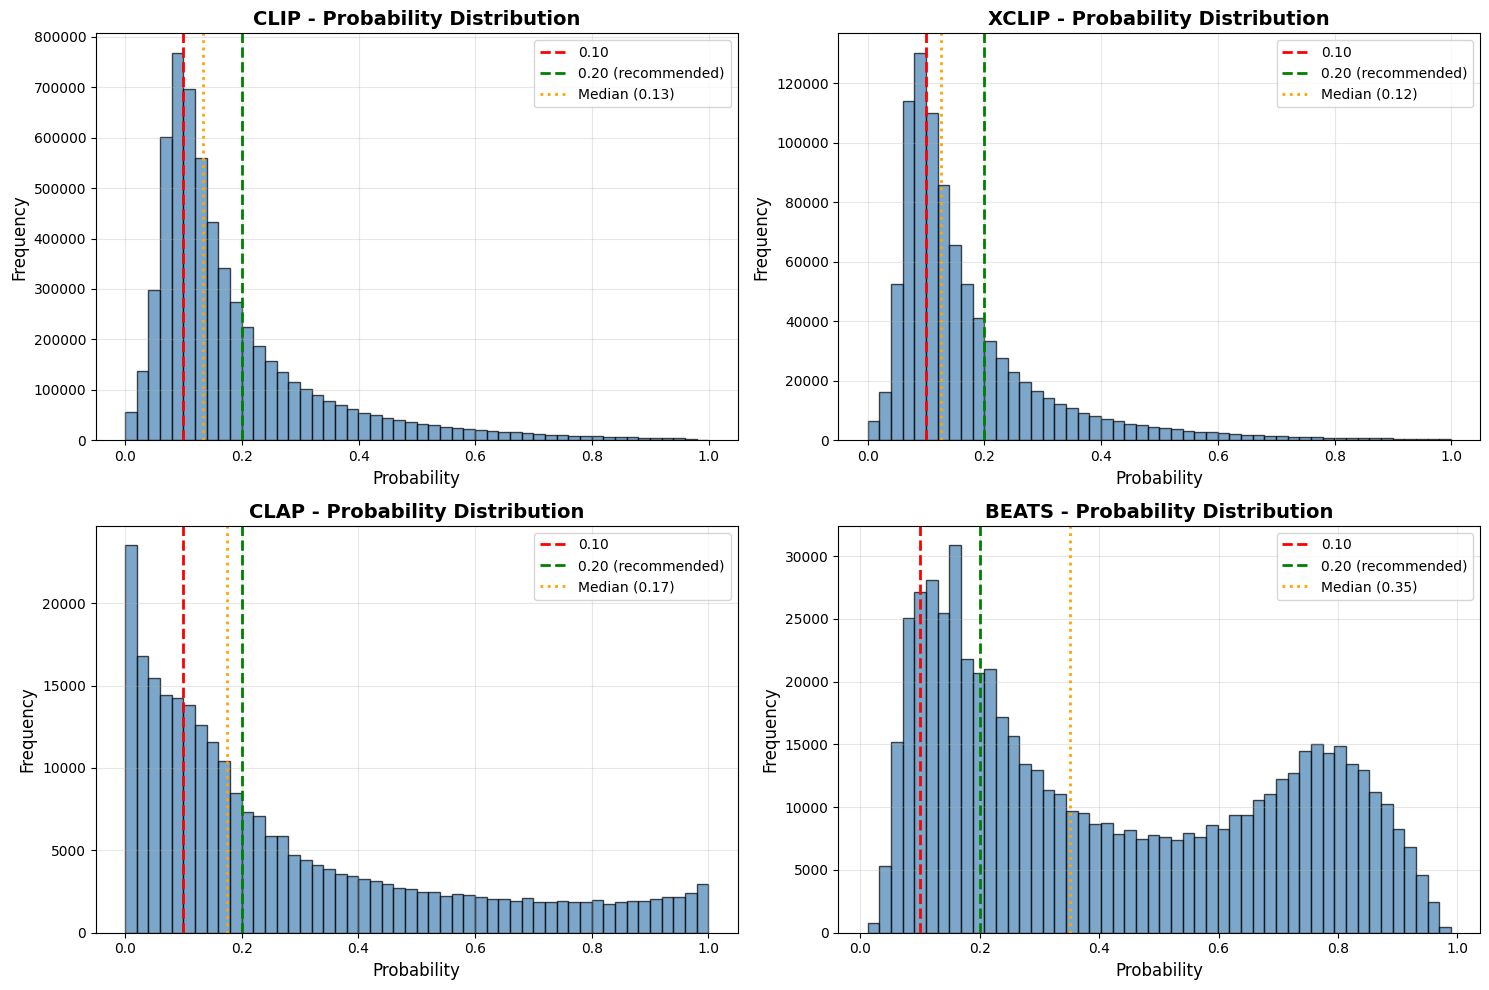


SUMMARY STATISTICS TABLE (RAW DATA)


,model,total_labels,mean,median,std,p25,p50,p75,p90
0,clip,5930148,0.185342,0.134,0.151519,0.090,0.134,0.225,0.384
1,xclip,915162,0.172042,0.125,0.139216,0.085,0.125,0.206,0.344
2,clap,259368,0.279519,0.174,0.272618,0.072,0.174,0.416,0.751
3,beats,613107,0.423209,0.351,0.278714,0.164,0.351,0.697,0.826


In [23]:
# Run analysis on RAW results (before any filtering)
stats_df = analyze_probability_distributions_raw(model_files)

print("\n" + "="*80)
print("SUMMARY STATISTICS TABLE (RAW DATA)")
print("="*80)
display(stats_df)


In [26]:
print("="*80)
print("THRESHOLD JUSTIFICATION: 0.20")
print("="*80)

justification = """
Based on the probability analysis of all labels:

1. **CLIP & XCLIP (Vision/Video)**:
   - Median ~0.13: Most predictions are low-confidence
   - 0.20 threshold filters top 25-30% (highest quality)
   - Removes 70% of noisy, uncertain predictions
   
2. **CLAP (Audio Classification)**:
   - Median 0.174: Moderate confidence
   - 0.20 threshold keeps top 45% of predictions
   - Good balance between signal and noise
   
3. **BEATS (Audio Events)**:
   - Median 0.351: High confidence model
   - 0.20 threshold retains 68.6% of labels
   - Natural high confidence, threshold doesn't over-filter

4. **Overall Benefits**:
   Keeps predictions with >20% confidence
   Removes ~60% of total labels (reduces token cost)
   Retains high-quality signals for LLM judge
   Consistent threshold across all modalities
   
5. **Statistical Support**:
   - Above 25th percentile for vision models
   - Near 50th percentile for CLAP
   - Well below median for BEATS (preserves confident predictions)
"""

print(justification)

# Calculate total reduction
total_labels_raw = 5_930_148 + 915_162 + 259_368 + 613_107
labels_after_020 = 1_762_369 + 240_523 + 117_992 + 420_498

reduction = total_labels_raw - labels_after_020
reduction_pct = (reduction / total_labels_raw) * 100

print(f"\nImpact of 0.20 Threshold:")
print(f"  Before: {total_labels_raw:,} labels")
print(f"  After:  {labels_after_020:,} labels")
print(f"  Removed: {reduction:,} labels ({reduction_pct:.1f}%)")
print(f"  Retained: {100-reduction_pct:.1f}% (highest confidence)")
print("="*80)

THRESHOLD JUSTIFICATION: 0.20

Based on the probability analysis of all labels:

1. **CLIP & XCLIP (Vision/Video)**:
   - Median ~0.13: Most predictions are low-confidence
   - 0.20 threshold filters top 25-30% (highest quality)
   - Removes 70% of noisy, uncertain predictions

2. **CLAP (Audio Classification)**:
   - Median 0.174: Moderate confidence
   - 0.20 threshold keeps top 45% of predictions
   - Good balance between signal and noise

3. **BEATS (Audio Events)**:
   - Median 0.351: High confidence model
   - 0.20 threshold retains 68.6% of labels
   - Natural high confidence, threshold doesn't over-filter

4. **Overall Benefits**:
   Keeps predictions with >20% confidence
   Removes ~60% of total labels (reduces token cost)
   Retains high-quality signals for LLM judge
   Consistent threshold across all modalities

5. **Statistical Support**:
   - Above 25th percentile for vision models
   - Near 50th percentile for CLAP
   - Well below median for BEATS (preserves confident pre

### Check model availability for each video and filter results

In [7]:
availability= check_model_availability(video_paths, model_files)

Checking clip...
  Found 3556 videos with results
Checking xclip...
  Found 3556 videos with results
Checking clap...
  Found 3556 videos with results
Checking beats...
  Found 3555 videos with results
Checking gemini...
  Found 3550 videos with results
Checking whisper...
  Found 2581 videos with results
Checking qwen...
  Found 3654 videos with results
  clip                : 3556 (100.0%)
  xclip               : 3556 (100.0%)
  clap                : 3556 (100.0%)
  beats               : 3555 (100.0%)
  gemini              : 3550 ( 99.8%)
  whisper             : 2581 ( 72.6%)
  qwen                : 3336 ( 93.8%)



Filter results and keep labels whose probabilities are higher than the threshold. 
- Low-confidence predictions (<0.20) are often misclassifications
- Fewer labels = less tokens, lower GPT cost

In [8]:
# Then filter results (only processes videos where availability[model_name] == True)
filtered_results = filter_and_prepare_model_results(
    video_paths_df=availability,
    model_files=model_files,
    probability_threshold=0.2
)


Processing clip...
  ✅ Processed 7112 videos

Processing xclip...
  ✅ Processed 7112 videos

Processing clap...
  ✅ Processed 7112 videos

Processing beats...
  ✅ Processed 3556 videos

Processing gemini...
  ✅ Processed 3556 videos

Processing whisper...
  ✅ Processed 2581 videos

Processing qwen...
  ✅ Processed 3894 videos

FILTERING STATISTICS

beats:
  Videos with results: 3555

clip:
  Videos with results: 3556

clap:
  Videos with results: 3556

xclip:
  Videos with results: 3556



Apply second filtering: merge consecutive segments
- LLM sees only meaningful predictions and not repetitions of the same thing

In [11]:
merged_results = helpers.merge_consecutive_segments(
    filtered_results=filtered_results,
    models_to_merge=['clip', 'xclip', 'beats']  # Only merge these models
)

  A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A  | clip : 146 →  56 (61.6% reduction)
  A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A  | xclip:  27 →   8 (70.4% reduction)
  A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A  | beats:  32 →  23 (28.1% reduction)
  A.Beautiful.Mind.2001__#00-03-00_00-04-05_label_A  | clip : 138 →  72 (47.8% reduction)
  A.Beautiful.Mind.2001__#00-03-00_00-04-05_label_A  | xclip:  26 →  14 (46.2% reduction)
  A.Beautiful.Mind.2001__#00-03-00_00-04-05_label_A  | beats:  32 →  14 (56.2% reduction)
  A.Beautiful.Mind.2001__#00-04-20_00-05-35_label_A  | clip : 217 →  89 (59.0% reduction)
  A.Beautiful.Mind.2001__#00-04-20_00-05-35_label_A  | xclip:  26 →  15 (42.3% reduction)
  A.Beautiful.Mind.2001__#00-04-20_00-05-35_label_A  | beats:  37 →  23 (37.8% reduction)
  A.Beautiful.Mind.2001__#00-05-52_00-08-22_label_A  | clip : 393 → 100 (74.6% reduction)
  A.Beautiful.Mind.2001__#00-05-52_00-08-22_label_A  | xclip:  61 →  45 (26.2% reduction)
  A.Beauti

In [38]:
# Save availability DataFrame and filtered results
availability.to_csv(MODEL_AVAILABILITY_OUTPUT, index=False)

with open(FILTERED_RESULTS_OUTPUT, "w", encoding="utf-8") as f:
    json.dump(filtered_results, f, indent=2)

with open(MERGED_RESULTS_OUTPUT, "w", encoding="utf-8") as f:
    json.dump(merged_results, f, indent=2)

# Print summary
print(f"\n{'='*60}")
print("SAVED FILES")
print(f"{'='*60}")
print(f"\n1. Model Availability:")
print(f"   Path: {MODEL_AVAILABILITY_OUTPUT}")
print(f"   Videos: {len(availability)}")
print(f"   Columns: {list(availability.columns)}")

print(f"\n2. Filtered Results:")
print(f"   Path: {FILTERED_RESULTS_OUTPUT}")
print(f"   Videos: {len(filtered_results)}")

print(f"\n3. Merged Results:")
print(f"   Path: {MERGED_RESULTS_OUTPUT}")
print(f"   Videos: {len(merged_results)}")


SAVED FILES

1. Model Availability:
   Path: ../../data/metadata/model_availability.csv
   Videos: 3556
   Columns: ['video_name', 'local_path', 'download_url', 'clip', 'xclip', 'clap', 'beats', 'gemini', 'whisper', 'qwen']

2. Filtered Results:
   Path: ../../data/results/zero_shot_classification/filtered_model_results.json
   Videos: 3556

3. Merged Results:
   Path: ../../data/results/zero_shot_classification/merged_model_results.json
   Videos: 3556


### Run zero-shot classification with gpt model

In [12]:
# Initialize evaluator
evaluator = GPTViolenceEvaluator(
    api_key=os.getenv("OPENAI_API_KEY"),
    model=MODEL_NAME
)

print(f"Initialized GPT Evaluator with model: {MODEL_NAME}")

Initialized GPT Evaluator with model: gpt-5


#### With models CLIP, XCLIP, BEATS, CLAP, GEMINI (API-Based transcripts)

In [13]:
# Define available models
available_models = [
    "CLIP - Vision-language zero-shot classification",
    "XCLIP - Video-language zero-shot classification", 
    "CLAP - Audio-language zero-shot classification",
    "BEATS - Audio event detection",
    "Gemini - Multimodal transcription",
]
# "Whisper - Speech-to-text transcription",
# "Qwen - Visual question answering"
# Format the prompt with models list
models_list_str = "\n".join(f"- {model}" for model in available_models)
system_prompt = prompt.replace("{models_list}", models_list_str)


##### Functions

In [14]:
def create_batches_of_videos(video_results: dict, batch_size: int = 500):
    """
    Split video results into smaller batches for processing.
    
    Args:
        video_results: Dict of all video results
        batch_size: Number of videos per batch (default: 500)
    
    Returns:
        list: List of dicts, each containing batch_size videos
    """
    video_names = list(video_results.keys())
    batches = []
    
    for i in range(0, len(video_names), batch_size):
        batch_videos = video_names[i:i + batch_size]
        batch_dict = {vid: video_results[vid] for vid in batch_videos}
        batches.append({
            'batch_num': i // batch_size + 1,
            'start_idx': i,
            'end_idx': min(i + batch_size, len(video_names)),
            'video_count': len(batch_videos),
            'videos': batch_dict
        })
    
    return batches

async def process_batch_chunk(
    evaluator: GPTViolenceEvaluator,
    batch_chunk: dict,
    system_prompt: str,
    models_to_include: list,
    output_dir: str,
    experiment_name: str = "api_based"
):
    """
    Process a single batch chunk (500 videos) through Batch API.
    
    Args:
        evaluator: GPTViolenceEvaluator instance
        batch_chunk: Dict from create_batches_of_videos()
        system_prompt: System prompt
        models_to_include: List of models to include
        output_dir: Directory to save results
        experiment_name: Name of experiment (for file naming)
    
    Returns:
        dict: Batch processing results
    """
    batch_num = batch_chunk['batch_num']
    start_idx = batch_chunk['start_idx']
    end_idx = batch_chunk['end_idx']
    
    print(f"\n{'='*80}")
    print(f"PROCESSING BATCH {batch_num}")
    print(f"Videos: {start_idx} to {end_idx} ({batch_chunk['video_count']} videos)")
    print(f"{'='*80}\n")
    
    # 1. Create batch input file
    batch_input_file = f"{output_dir}/{experiment_name}_batch_{batch_num}_input.jsonl"
    print(f"Creating batch input file...")
    evaluator.create_batch_input_file(
        video_results=batch_chunk['videos'],
        system_prompt=system_prompt,
        output_file=batch_input_file,
        models_to_include=models_to_include
    )
    
    # 2. Upload to OpenAI
    print(f"Uploading to OpenAI...")
    batch_file_id = await evaluator.upload_batch_file(batch_input_file)
    print(f"✅ Uploaded: {batch_file_id}")
    
    # 3. Create batch job
    print(f"Creating batch job...")
    batch = await evaluator.create_batch(batch_file_id, "24h")
    print(f"✅ Batch created: {batch.id}")
    
    # 4. Save batch metadata
    batch_info = {
        "batch_num": batch_num,
        "batch_id": batch.id,
        "batch_file_id": batch_file_id,
        "status": batch.status,
        "input_file": batch_input_file,
        "start_idx": start_idx,
        "end_idx": end_idx,
        "video_count": batch_chunk['video_count'],
        "video_names": list(batch_chunk['videos'].keys()),
        "model": evaluator.model,
        "created_at": str(batch.created_at),
        "models_included": models_to_include
    }

    
    # Save to JSON
    metadata_file = f"{output_dir}/{experiment_name}_batch_{batch_num}_metadata.json"
    with open(metadata_file, "w", encoding="utf-8") as f:
        json.dump(batch_info, f, indent=2)
    
    print(f"✅ Metadata saved: {metadata_file}")
    
    return batch_info

##### Testing

In [72]:
# Test batch API with first 5 videos from filtered results
# sample 5 videos
test_videos = [list(filtered_results)[0], list(filtered_results)[120], list(filtered_results)[2030], list(filtered_results)[3123], list(filtered_results)[1500], list(filtered_results)[521]]
print(f"Testing with {len(test_videos)} videos:")
for i, vid in enumerate(test_videos, 1):
    print(f"  {i}. {vid}")

Testing with 6 videos:
  1. A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A
  2. Before.Sunset.2004__#00-16-18_00-18-09_label_A
  3. v=bunhcwSvil8__#1_label_B4-0-0
  4. v=vFPQ_NiDBIU__#01-24-00_01-30-00_label_A
  5. The.Intouchables.2011__#00-23-50_00-24-31_label_A
  6. GoldenEye.1995__#00-05-41_00-07-32_label_B2-G-0


In [ ]:
# 1. Create batch input
batch_input_file = evaluator.create_batch_input_file(
    video_results={vid: merged_results[vid] for vid in test_videos},
    system_prompt=system_prompt,
    output_file= "batch_input.jsonl",
    models_to_include = ['clip', 'xclip', 'clap', 'beats', 'gemini']
)
# 2. Upload file
print("\n Uploading to OpenAI...")
batch_file_id = await evaluator.upload_batch_file(batch_input_file)
# 3. Create batch job
print("\n Creating batch job...")
batch = await evaluator.create_batch(batch_file_id, "24h")
# 4. Save batch info
batch_info = {
    "batch_id": batch.id,
    "batch_file_id": batch_file_id,
    "status": batch.status,
    "input_file": batch_input_file,
    "videos": test_videos,
    "model": MODEL_NAME,
    "created_at": str(batch.created_at)
}
batch_info

In [76]:
# 5. Retrieve the status of a batch.
batch_status, output_file_id = await evaluator.get_batch_status(batch.id) #batch.id
print(batch_status)

completed


In [77]:
# 6. When the batch is complete, download the results
file_response = await evaluator.download_batch_output(output_file_id)

In [ ]:
# save results to JSON and CSV
output_json = "../../data/results/zero_shot_classification/llm_judge_api_based/test_batch_results2.json"
results = helpers.parse_batch_results_to_json(file_response, output_json)

output_csv = "../../data/results/zero_shot_classification/llm_judge_api_based/test_batch_results2.csv"
df = helpers.parse_batch_results_to_csv(file_response, output_csv)

# Display summary
display(df[['video_name', 'violence_probability', 'confidence', 'abstain', 'primary_models']])

Saved 6 results to: ../../data/results/zero_shot_classification/llm_judge_api_based/test_batch_results2.json
Saved 6 results to: ../../data/results/zero_shot_classification/llm_judge_api_based/test_batch_results2.csv


,video_name,violence_probability,confidence,abstain,primary_models
0,A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A,0.08,0.73,False,gemini|clap|beats|clip|xclip
1,Before.Sunset.2004__#00-16-18_00-18-09_label_A,0.09,0.72,False,
2,v=bunhcwSvil8__#1_label_B4-0-0,0.95,0.92,False,
3,v=vFPQ_NiDBIU__#01-24-00_01-30-00_label_A,0.20,0.36,False,gemini|clip|xclip|beats|clap
4,The.Intouchables.2011__#00-23-50_00-24-31_label_A,0.10,0.70,False,
5,GoldenEye.1995__#00-05-41_00-07-32_label_B2-G-0,0.96,0.93,False,gemini|xclip|clip|beats|clap


##### Run Batch

In [15]:
# Split videos into batches of 500
batches = create_batches_of_videos(merged_results, batch_size=500)

print(f"Total batches to process: {len(batches)}")
for i, batch in enumerate(batches, 1):
    print(f"  Batch {i}: Videos {batch['start_idx']}-{batch['end_idx']} ({batch['video_count']} videos)")



Total batches to process: 8
  Batch 1: Videos 0-500 (500 videos)
  Batch 2: Videos 500-1000 (500 videos)
  Batch 3: Videos 1000-1500 (500 videos)
  Batch 4: Videos 1500-2000 (500 videos)
  Batch 5: Videos 2000-2500 (500 videos)
  Batch 6: Videos 2500-3000 (500 videos)
  Batch 7: Videos 3000-3500 (500 videos)
  Batch 8: Videos 3500-3556 (56 videos)


In [ ]:
# Process batches one at a time
# CONTROL WHICH BATCH TO PROCESS
batch_to_process = 8  # Change this: 1, 2, 3, 4, etc.

batch_info = await process_batch_chunk(
    evaluator=evaluator,
    batch_chunk=batches[batch_to_process - 1],  # Index is 0-based
    system_prompt=system_prompt,
    models_to_include=['clip', 'xclip', 'clap', 'beats', 'gemini'],
    output_dir="../../data/results/zero_shot_classification/llm_judge_api_based/input",
    experiment_name="api_based"
)

batch_info

In [ ]:
# Retrieve the status of a batch.
batch_status, output_file_id = await evaluator.get_batch_status(batch_info['batch_id']) #batch_info['batch_id']
print(batch_status)

completed


In [33]:
# When the batch is complete, download the results
file_response = await evaluator.download_batch_output(output_file_id)

In [34]:
# save results to JSON and CSV
output_json = "../../data/results/zero_shot_classification/llm_judge_api_based/output/batch_results8.json"
results = helpers.parse_batch_results_to_json(file_response, output_json)

output_csv = "../../data/results/zero_shot_classification/llm_judge_api_based/output/batch_results8.csv"
df = helpers.parse_batch_results_to_csv(file_response, output_csv)


Saved 56 results to: ../../data/results/zero_shot_classification/llm_judge_api_based/output/batch_results8.json
Saved 56 results to: ../../data/results/zero_shot_classification/llm_judge_api_based/output/batch_results8.csv


#### With models CLIP, XCLIP, BEATS, CLAP, WHISPER, QWEN (Open Source-Based transcripts)

In [36]:
# Define available models
available_models = [
    "CLIP - Vision-language zero-shot classification",
    "XCLIP - Video-language zero-shot classification", 
    "CLAP - Audio-language zero-shot classification",
    "BEATS - Audio event detection",
    "Whisper - Speech-to-text transcription",
    "Qwen - Visual transcription"
]
# Format the prompt with models list
models_list_str = "\n".join(f"- {model}" for model in available_models)
system_prompt = prompt.replace("{models_list}", models_list_str)

##### Testing

In [ ]:
# 1. Create batch input
batch_input_file = evaluator.create_batch_input_file(
    video_results={vid: filtered_results[vid] for vid in test_videos},
    system_prompt=system_prompt,
    output_file= "batch_input.jsonl",
    models_to_include = ['clip', 'xclip', 'clap', 'beats', 'whisper', 'qwen']
)
# 2. Upload file
print("\n Uploading to OpenAI...")
batch_file_id = await evaluator.upload_batch_file(batch_input_file)
# 3. Create batch job
print("\n Creating batch job...")
batch = await evaluator.create_batch(batch_file_id, "24h")
# 4. Save batch info
batch_info = {
    "batch_id": batch.id,
    "batch_file_id": batch_file_id,
    "status": batch.status,
    "input_file": batch_input_file,
    "videos": test_videos,
    "model": MODEL_NAME,
    "created_at": str(batch.created_at)
}
batch_info

In [ ]:
# 5. Retrieve the status of a batch.
batch_status, output_file_id = await evaluator.get_batch_status(batch.id) #batch.id
print(batch_status)

completed


In [66]:
# 6. When the batch is complete, download the results
file_response = await evaluator.download_batch_output(output_file_id)

In [67]:
# save results to JSON and CSV
output_json = "../../data/results/zero_shot_classification/llm_judge_open_source/test_batch_results.json"
results = helpers.parse_batch_results_to_json(file_response, output_json)

output_csv = "../../data/results/zero_shot_classification/llm_judge_open_source/test_batch_results.csv"
df = helpers.parse_batch_results_to_csv(file_response, output_csv)

# Display summary
display(df[['video_name', 'violence_probability', 'confidence', 'abstain', 'primary_models']])

Saved 6 results to: ../../data/results/zero_shot_classification/llm_judge_open_source/test_batch_results.json
Saved 6 results to: ../../data/results/zero_shot_classification/llm_judge_open_source/test_batch_results.csv


,video_name,violence_probability,confidence,abstain,primary_models
0,A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A,0.18,0.56,False,whisper|qwen|clap|beats|xclip|clip
1,Before.Sunset.2004__#00-16-18_00-18-09_label_A,0.20,0.47,False,whisper|qwen|beats|clap|xclip|clip
2,v=bunhcwSvil8__#1_label_B4-0-0,0.93,0.88,False,whisper|clip|qwen|beats|xclip|clap
3,v=vFPQ_NiDBIU__#01-24-00_01-30-00_label_A,0.09,0.70,False,qwen|beats|clap|xclip|clip
4,The.Intouchables.2011__#00-23-50_00-24-31_label_A,0.84,0.66,False,clip|xclip|whisper|clap|beats
5,GoldenEye.1995__#00-05-41_00-07-32_label_B2-G-0,0.98,0.96,False,qwen|whisper|beats|clip|xclip|clap


#### Run batch

In [38]:
# Split videos into batches of 500
batches = create_batches_of_videos(merged_results, batch_size=500)

print(f"Total batches to process: {len(batches)}")
for i, batch in enumerate(batches, 1):
    print(f"  Batch {i}: Videos {batch['start_idx']}-{batch['end_idx']} ({batch['video_count']} videos)")



Total batches to process: 8
  Batch 1: Videos 0-500 (500 videos)
  Batch 2: Videos 500-1000 (500 videos)
  Batch 3: Videos 1000-1500 (500 videos)
  Batch 4: Videos 1500-2000 (500 videos)
  Batch 5: Videos 2000-2500 (500 videos)
  Batch 6: Videos 2500-3000 (500 videos)
  Batch 7: Videos 3000-3500 (500 videos)
  Batch 8: Videos 3500-3556 (56 videos)


In [ ]:
# Process batches one at a time
# CONTROL WHICH BATCH TO PROCESS
batch_to_process = 8  # Change this: 1, 2, 3, 4, etc.

batch_info = await process_batch_chunk(
    evaluator=evaluator,
    batch_chunk=batches[batch_to_process - 1],  # Index is 0-based
    system_prompt=system_prompt,
    models_to_include=['clip', 'xclip', 'clap', 'beats', 'whisper', 'qwen'],
    output_dir="../../data/results/zero_shot_classification/llm_judge_open_source/input",
    experiment_name="open_source"
)

batch_info

In [90]:
# Retrieve the status of a batch.
batch_status, output_file_id = await evaluator.get_batch_status(batch_info['batch_id']) #batch_info['batch_id']
print(batch_status)

completed


In [91]:
# When the batch is complete, download the results
file_response = await evaluator.download_batch_output(output_file_id)

In [92]:
# save results to JSON and CSV
output_json = "../../data/results/zero_shot_classification/llm_judge_open_source/output/batch_results8.json"
results = helpers.parse_batch_results_to_json(file_response, output_json)

output_csv = "../../data/results/zero_shot_classification/llm_judge_open_source/output/batch_results8.csv"
df = helpers.parse_batch_results_to_csv(file_response, output_csv)


Saved 56 results to: ../../data/results/zero_shot_classification/llm_judge_open_source/output/batch_results8.json
Saved 56 results to: ../../data/results/zero_shot_classification/llm_judge_open_source/output/batch_results8.csv


### Run zero-shot classification with open source models

#### Using Ollama

In [7]:
# Initialize Ollama evaluator
ollama_evaluator = OllamaViolenceEvaluator(
    model= OLLAMA_MODEL_NAME, # OLLAMA_MODEL_NAME,  # "qwen3:14b-q8_0"
    base_url="http://localhost:11434",
    request_timeout= 10200
)

Connected to Ollama - Model: qwen3:14b-q8_0
   Test response: Hello! I'm here and ready to help whenever you nee...


In [8]:
# Get prompt
prompt_path = "../../data/prompts/llm_judge_local.txt"
with open(prompt_path, "r", encoding="utf-8") as f:
    prompt = f.read()

In [9]:
# Define available models
available_models = [
    "CLAP - Audio-language zero-shot classification",
    "BEATS - Audio event detection",
    "Whisper - Speech-to-text transcription",
    "Qwen - Visual transcription"
]
# Format the prompt with models list
models_list_str = "\n".join(f"- {model}" for model in available_models)
system_prompt = prompt.replace("{models_list}", models_list_str)
models_to_include = ['clap', 'beats', 'whisper', 'qwen']

In [ ]:
def save_result_incrementally(result: dict, output_file: str):
    """
    Save a single result to JSON file. If file exists, append to it.
    
    Args:
        result: Dict containing evaluation result
        output_file: Path to JSON file
    """
    
    # Extract only the fields we want
    result_to_save = {
        "video_name": result.get("video_name", ""),
        "violence_probability": result.get("response", {}).get("violence_probability", 0.0),
        "confidence": result.get("response", {}).get("confidence", 0.0),
        "abstain": result.get("response", {}).get("abstain", True),
        "rationale": result.get("response", {}).get("rationale", ""),
        "primary_modalities": result.get("response", {}).get("primary_modalities", [])
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Load existing results or create new list
    if os.path.exists(output_file):
        with open(output_file, "r", encoding="utf-8") as f:
            try:
                existing_results = json.load(f)
                if not isinstance(existing_results, list):
                    existing_results = []
            except json.JSONDecodeError:
                existing_results = []
    else:
        existing_results = []
    
    # Check if video already exists (avoid duplicates)
    video_names = {r.get("video_name") for r in existing_results}
    if result_to_save["video_name"] not in video_names:
        existing_results.append(result_to_save)
        
        # Save back to file
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(existing_results, f, indent=2, ensure_ascii=False)
        
        return True  # Saved
    else:
        return False  # Already exists
    
def process_videos_incrementally(
    video_names: list,
    merged_results: dict,
    ollama_evaluator,
    system_prompt: str,
    models_to_include: list,
    output_file: str,
    start_idx: int = 0,
    end_idx: int = None,
    save_every: int = 1
):
    """
    Process videos in increments and save results after each video.
    
    Args:
        video_names: List of all video names
        merged_results: Dict of video results
        ollama_evaluator: OllamaViolenceEvaluator instance
        system_prompt: System prompt
        models_to_include: List of models to include
        output_file: Path to save results
        start_idx: Start index (for resuming)
        end_idx: End index (None = process all)
        save_every: Save progress every N videos
    """
    if end_idx is None:
        end_idx = len(video_names)
    
    print(f"Processing videos {start_idx} to {end_idx} ({end_idx - start_idx} videos)")
    print(f"Output: {output_file}\n")
    
    # Load existing results to track progress
    processed_videos = set()
    if os.path.exists(output_file):
        with open(output_file, "r", encoding="utf-8") as f:
            try:
                existing = json.load(f)
                processed_videos = {r.get("video_name") for r in existing}
                print(f"Found {len(processed_videos)} already processed videos\n")
            except:
                pass
    
    successful = 0
    failed = 0
    skipped = 0
    
    for i in range(start_idx, end_idx):
        video_name = video_names[i]
        
        # Skip if already processed
        if video_name in processed_videos:
            print(f"[{i+1}/{end_idx}] ⏭️  {video_name} (already processed)")
            skipped += 1
            continue
        
        print(f"[{i+1}/{end_idx}] Processing {video_name}...")
        
        try:
            # Evaluate video
            result = ollama_evaluator.evaluate_video(
                video_name=video_name,
                video_results=merged_results[video_name],
                system_prompt=system_prompt,
                models_to_include=models_to_include
            )
            
            # Save result immediately
            saved = save_result_incrementally(result, output_file)
        
        except KeyboardInterrupt:
            print(f"\n\nInterrupted by user at video {i+1}/{end_idx}")
            print(f"Progress saved to: {output_file}")
            print(f"Resume from index: {i}")
            break
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed += 1

In [ ]:
# Load the merged results
with open(MERGED_RESULTS_OUTPUT, "r", encoding="utf-8") as f:
    merged_results = json.load(f)

video_names = list(merged_results.keys())

# Process in increments (e.g., first 100 videos)
process_videos_incrementally(
    video_names=video_names,
    merged_results=merged_results,
    ollama_evaluator=ollama_evaluator,
    system_prompt=system_prompt,
    models_to_include=models_to_include,
    output_file=OLLAMA_OPEN_SOURCE_OUTPUT,
    start_idx=0,      # Start from video 0
    end_idx=500,      # Process up to video 100
    save_every=10     # Print progress every 10 videos
)

#### Using qwen 30b (resource limits, ran it using Alibaba cloud)

In [9]:
# Load the merged results
with open(MERGED_RESULTS_OUTPUT, "r", encoding="utf-8") as f:
    merged_results = json.load(f)
    
# Get prompt
prompt_path = "../../data/prompts/llm_judge_qwen3.txt"
with open(prompt_path, "r", encoding="utf-8") as f:
    prompt = f.read()

# Define available models
available_models = [
    "CLIP - Vision-language zero-shot classification",
    "XCLIP - Video-language zero-shot classification", 
    "CLAP - Audio-language zero-shot classification",
    "BEATS - Audio event detection",
    "Whisper - Speech-to-text transcription",
    "Qwen - Visual transcription"
]
# Format the prompt with models list
models_list_str = "\n".join(f"- {model}" for model in available_models)
system_prompt = prompt.replace("{models_list}", models_list_str)
models_to_include = ['clip', 'xclip', 'clap', 'beats', 'whisper', 'qwen']

In [ ]:
# # Load the merged results
# with open(MERGED_RESULTS_OUTPUT, "r", encoding="utf-8") as f:
#     merged_results = json.load(f)
# # Test batch API with first 5 videos from filtered results

# test_videos = ['v=BzwNU2xmT64__#00-10-30_00-10-51_label_B6-0-0','A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A','Bad.Boys.1995__#00-42-10_00-45-45_label_A', 'Bad.Boys.1995__#01-30-37_01-32-44_label_A','Bad.Boys.1995__#01-52-45_01-53-19_label_B2-0-0', 'Before.Sunset.2004__#00-16-18_00-18-09_label_A', 'v=bunhcwSvil8__#1_label_B4-0-0','v=vFPQ_NiDBIU__#01-24-00_01-30-00_label_A', 'The.Intouchables.2011__#00-23-50_00-24-31_label_A', 'GoldenEye.1995__#00-05-41_00-07-32_label_B2-G-0', "v=7OM8znTZYkk__#1_label_B4-0-0"]
# print(f"Testing with {len(test_videos)} videos:")
# for i, vid in enumerate(test_videos, 1):
#     print(f"  {i}. {vid}")
# test_data = {vid: merged_results[vid] for vid in test_videos}

Testing with 11 videos:
  1. v=BzwNU2xmT64__#00-10-30_00-10-51_label_B6-0-0
  2. A.Beautiful.Mind.2001__#00-01-45_00-02-50_label_A
  3. Bad.Boys.1995__#00-42-10_00-45-45_label_A
  4. Bad.Boys.1995__#01-30-37_01-32-44_label_A
  5. Bad.Boys.1995__#01-52-45_01-53-19_label_B2-0-0
  6. Before.Sunset.2004__#00-16-18_00-18-09_label_A
  7. v=bunhcwSvil8__#1_label_B4-0-0
  8. v=vFPQ_NiDBIU__#01-24-00_01-30-00_label_A
  9. The.Intouchables.2011__#00-23-50_00-24-31_label_A
  10. GoldenEye.1995__#00-05-41_00-07-32_label_B2-G-0
  11. v=7OM8znTZYkk__#1_label_B4-0-0


In [ ]:
# Test with sample videos
evaluator = QwenViolenceEvaluator(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    model_name="qwen3-30b-a3b-thinking-2507"
)

results = await evaluator.evaluate_videos_batch(
    video_results= merged_results, #merged_results,
    system_prompt=system_prompt,
    models_to_include=models_to_include,
    batch_size=20,
    output_json= QWEN_OPEN_SOURCE_OUTPUT  #QWEN_OPEN_SOURCE_OUTPUT
)


In [ ]:
# Parse results from the raw JSON file
evaluator.parse_and_save_results(
    input_json=QWEN_OPEN_SOURCE_OUTPUT,  # "../../data/results/.../incremental_results.json"
    output_json="../../data/results/zero_shot_classification/llm_judge_qwen/results_alt_prompt2.json",
    output_csv="../../data/results/zero_shot_classification/llm_judge_qwen/results_alt_prompt2.csv",
    metadata_json="../../data/results/zero_shot_classification/llm_judge_qwen/metadata_alt_prompt2.json",
    metadata_csv="../../data/results/zero_shot_classification/llm_judge_qwen/metadata_alt_prompt2.csv"
)